# Method 1 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

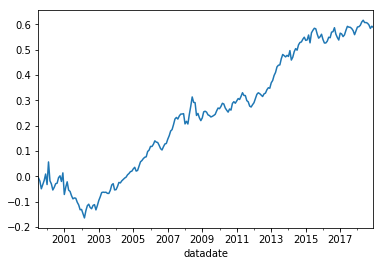

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.009269
2000-12-31    0.004514
2001-12-31   -0.143488
2002-12-31    0.019140
2003-12-31    0.069690
2004-12-31    0.078070
2005-12-31    0.081527
2006-12-31    0.023693
2007-12-31    0.104049
2008-12-31   -0.021945
2009-12-31    0.040652
2010-12-31    0.014963
2011-12-31   -0.004558
2012-12-31    0.050731
2013-12-31    0.096242
2014-12-31    0.048528
2015-12-31    0.007504
2016-12-31   -0.014606
2017-12-31    0.023580
2018-12-31    0.008604
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     11.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.01e-08
Time:                        15:16:20   Log-Likelihood:                 660.87
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1294.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.886      0.376      -0.001       0.003
mktrf          0.0260      0.027      0.962      0.337      -0.027       0.079
me             0.1962      0.031      6.231      0.000       0.134       0.258
ia            -0.0914      0.048     -1.909      0.057      -0.186       0.003
roe            0.1479      0.041      3.610      0.000       0.067       0.229
==============================================================================
Omnibus:                       76.697   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.333
Skew:                          -1.238   Prob(JB):                     1.03e-75
Kurtosis:                       8.412   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.486
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00165
Time:                        15:16:20   Log-Likelihood:                 660.87
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1294.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.722      0.470      -0.002       0.003
mktrf          0.0260      0.033      0.781      0.435      -0.039       0.091
me             0.1962      0.075      2.600      0.009       0.048       0.344
ia            -0.0914      0.114     -0.799      0.424      -0.316       0.133
roe            0.1479      0.055      2.674      0.008       0.039       0.256
==============================================================================
Omnibus:                       76.697   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.333
Skew:                          -1.238   Prob(JB):                     1.03e-75
Kurtosis:                       8.412   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.352
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00206
Time:                        15:16:20   Log-Likelihood:                 660.87
No. Observations:                 234   AIC:                            -1312.
Df Residuals:                     229   BIC:                            -1294.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.616      0.538      -0.002       0.004
mktrf          0.0260      0.025      1.033      0.302      -0.023       0.075
me             0.1962      0.079      2.491      0.013       0.042       0.351
ia            -0.0914      0.101     -0.901      0.368      -0.290       0.107
roe            0.1479      0.051      2.889      0.004       0.048       0.248
==============================================================================
Omnibus:                       76.697   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.333
Skew:                          -1.238   Prob(JB):                     1.03e-75
Kurtosis:                       8.412   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.162
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000166
Time:                        15:16:20   Log-Likelihood:                 652.68
No. Observations:                 234   AIC:                            -1293.
Df Residuals:                     228   BIC:                            -1273.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.566      0.119      -0.000       0.004
mktrf         -0.0051      0.028     -0.181      0.856      -0.061       0.050
smb            0.1353      0.037      3.641      0.000       0.062       0.208
hml           -0.0971      0.044     -2.217      0.028      -0.183      -0.011
rmw            0.0008      0.050      0.017      0.987      -0.097       0.098
cma            0.0901      0.063      1.431      0.154      -0.034       0.214
==============================================================================
Omnibus:                       81.272   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.490
Skew:                          -1.195   Prob(JB):                    1.16e-112
Kurtosis:                       9.867   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.801
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.114
Time:                        15:16:20   Log-Likelihood:                 652.68
No. Observations:                 234   AIC:                            -1293.
Df Residuals:                     228   BIC:                            -1273.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.622      0.105      -0.000       0.004
mktrf         -0.0051      0.030     -0.172      0.864      -0.063       0.053
smb            0.1353      0.062      2.165      0.030       0.013       0.258
hml           -0.0971      0.046     -2.119      0.034      -0.187      -0.007
rmw            0.0008      0.068      0.012      0.990      -0.133       0.135
cma            0.0901      0.137      0.659      0.510      -0.178       0.358
==============================================================================
Omnibus:                       81.272   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.490
Skew:                          -1.195   Prob(JB):                    1.16e-112
Kurtosis:                       9.867   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.051
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0726
Time:                        15:16:20   Log-Likelihood:                 652.68
No. Observations:                 234   AIC:                            -1293.
Df Residuals:                     228   BIC:                            -1273.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.459      0.145      -0.001       0.004
mktrf         -0.0051      0.028     -0.185      0.853      -0.059       0.049
smb            0.1353      0.055      2.465      0.014       0.028       0.243
hml           -0.0971      0.048     -2.021      0.043      -0.191      -0.003
rmw            0.0008      0.067      0.012      0.990      -0.130       0.132
cma            0.0901      0.148      0.608      0.543      -0.200       0.381
==============================================================================
Omnibus:                       81.272   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.490
Skew:                          -1.195   Prob(JB):                    1.16e-112
Kurtosis:                       9.867   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     27.98
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.31e-19
Time:                        15:16:20   Log-Likelihood:                 686.68
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.955      0.341      -0.001       0.003
mktrf          0.0679      0.022      3.041      0.003       0.024       0.112
smb            0.0765      0.028      2.746      0.007       0.022       0.131
hml            0.0057      0.028      0.207      0.836      -0.049       0.060
umd            0.1632      0.018      8.985      0.000       0.127       0.199
==============================================================================
Omnibus:                       40.798   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.531
Skew:                          -0.807   Prob(JB):                     1.80e-21
Kurtosis:                       5.682   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     10.59
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.90e-08
Time:                        15:16:20   Log-Likelihood:                 686.68
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.724      0.469      -0.001       0.003
mktrf          0.0679      0.024      2.799      0.005       0.020       0.115
smb            0.0765      0.052      1.477      0.140      -0.025       0.178
hml            0.0057      0.043      0.133      0.894      -0.079       0.090
umd            0.1632      0.039      4.154      0.000       0.086       0.240
==============================================================================
Omnibus:                       40.798   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.531
Skew:                          -0.807   Prob(JB):                     1.80e-21
Kurtosis:                       5.682   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     13.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.57e-10
Time:                        15:16:20   Log-Likelihood:                 686.68
No. Observations:                 234   AIC:                            -1363.
Df Residuals:                     229   BIC:                            -1346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.639      0.523      -0.002       0.003
mktrf          0.0679      0.018      3.735      0.000       0.032       0.104
smb            0.0765      0.040      1.901      0.057      -0.002       0.155
hml            0.0057      0.044      0.130      0.897      -0.081       0.093
umd            0.1632      0.040      4.116      0.000       0.085       0.241
==============================================================================
Omnibus:                       40.798   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.531
Skew:                          -0.807   Prob(JB):                     1.80e-21
Kurtosis:                       5.682   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     9.391
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-06
Time:                        15:16:20   Log-Likelihood:                 315.29
No. Observations:                 120   AIC:                            -620.6
Df Residuals:                     115   BIC:                            -606.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.371      0.712      -0.004       0.003
mktrf          0.0610      0.046      1.324      0.188      -0.030       0.152
me             0.2616      0.045      5.753      0.000       0.172       0.352
ia            -0.0915      0.071     -1.285      0.201      -0.233       0.050
roe            0.2373      0.063      3.766      0.000       0.112       0.362
==============================================================================
Omnibus:                       30.402   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.849
Skew:                          -1.087   Prob(JB):                     4.52e-13
Kurtosis:                       5.577   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     7.054
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.09e-05
Time:                        15:16:20   Log-Likelihood:                 315.29
No. Observations:                 120   AIC:                            -620.6
Df Residuals:                     115   BIC:                            -606.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.273      0.785      -0.005       0.004
mktrf          0.0610      0.052      1.165      0.244      -0.042       0.164
me             0.2616      0.090      2.896      0.004       0.085       0.439
ia            -0.0915      0.138     -0.663      0.507      -0.362       0.179
roe            0.2373      0.068      3.471      0.001       0.103       0.371
==============================================================================
Omnibus:                       30.402   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.849
Skew:                          -1.087   Prob(JB):                     4.52e-13
Kurtosis:                       5.577   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     8.035
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.50e-06
Time:                        15:16:20   Log-Likelihood:                 315.29
No. Observations:                 120   AIC:                            -620.6
Df Residuals:                     115   BIC:                            -606.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.229      0.819      -0.006       0.005
mktrf          0.0610      0.037      1.632      0.103      -0.012       0.134
me             0.2616      0.095      2.742      0.006       0.075       0.449
ia            -0.0915      0.125     -0.732      0.464      -0.336       0.153
roe            0.2373      0.054      4.386      0.000       0.131       0.343
==============================================================================
Omnibus:                       30.402   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.849
Skew:                          -1.087   Prob(JB):                     4.52e-13
Kurtosis:                       5.577   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.367
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00711
Time:                        15:16:20   Log-Likelihood:                 306.60
No. Observations:                 120   AIC:                            -601.2
Df Residuals:                     114   BIC:                            -584.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.312      0.755      -0.003       0.004
mktrf         -0.0151      0.052     -0.288      0.774      -0.119       0.089
smb            0.1840      0.059      3.098      0.002       0.066       0.302
hml           -0.0976      0.073     -1.341      0.183      -0.242       0.047
rmw            0.0314      0.086      0.366      0.715      -0.139       0.201
cma            0.1095      0.094      1.165      0.246      -0.077       0.296
==============================================================================
Omnibus:                       36.947   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.533
Skew:                          -1.125   Prob(JB):                     5.44e-23
Kurtosis:                       6.929   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.169
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0624
Time:                        15:16:20   Log-Likelihood:                 306.60
No. Observations:                 120   AIC:                            -601.2
Df Residuals:                     114   BIC:                            -584.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.325      0.745      -0.003       0.004
mktrf         -0.0151      0.058     -0.259      0.796      -0.129       0.099
smb            0.1840      0.088      2.082      0.037       0.011       0.357
hml           -0.0976      0.080     -1.216      0.224      -0.255       0.060
rmw            0.0314      0.120      0.261      0.794      -0.204       0.267
cma            0.1095      0.161      0.680      0.497      -0.206       0.425
==============================================================================
Omnibus:                       36.947   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.533
Skew:                          -1.125   Prob(JB):                     5.44e-23
Kurtosis:                       6.929   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.948
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0154
Time:                        15:16:21   Log-Likelihood:                 306.60
No. Observations:                 120   AIC:                            -601.2
Df Residuals:                     114   BIC:                            -584.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.282      0.778      -0.004       0.005
mktrf         -0.0151      0.059     -0.257      0.797      -0.130       0.100
smb            0.1840      0.079      2.334      0.020       0.030       0.338
hml           -0.0976      0.088     -1.108      0.268      -0.270       0.075
rmw            0.0314      0.128      0.245      0.806      -0.220       0.282
cma            0.1095      0.168      0.652      0.515      -0.220       0.439
==============================================================================
Omnibus:                       36.947   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.533
Skew:                          -1.125   Prob(JB):                     5.44e-23
Kurtosis:                       6.929   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     18.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-11
Time:                        15:16:21   Log-Likelihood:                 327.94
No. Observations:                 120   AIC:                            -645.9
Df Residuals:                     115   BIC:                            -631.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.289      0.773      -0.003       0.003
mktrf          0.0840      0.037      2.302      0.023       0.012       0.156
smb            0.0876      0.042      2.108      0.037       0.005       0.170
hml            0.0280      0.042      0.673      0.502      -0.054       0.110
umd            0.1841      0.026      7.174      0.000       0.133       0.235
==============================================================================
Omnibus:                       15.549   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.605
Skew:                          -0.761   Prob(JB):                     9.12e-05
Kurtosis:                       4.186   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     10.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-07
Time:                        15:16:21   Log-Likelihood:                 327.94
No. Observations:                 120   AIC:                            -645.9
Df Residuals:                     115   BIC:                            -631.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.204      0.838      -0.004       0.005
mktrf          0.0840      0.037      2.261      0.024       0.011       0.157
smb            0.0876      0.065      1.347      0.178      -0.040       0.215
hml            0.0280      0.052      0.544      0.587      -0.073       0.129
umd            0.1841      0.045      4.117      0.000       0.096       0.272
==============================================================================
Omnibus:                       15.549   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.605
Skew:                          -0.761   Prob(JB):                     9.12e-05
Kurtosis:                       4.186   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     17.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.06e-11
Time:                        15:16:21   Log-Likelihood:                 327.94
No. Observations:                 120   AIC:                            -645.9
Df Residuals:                     115   BIC:                            -631.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.176      0.860      -0.004       0.005
mktrf          0.0840      0.024      3.473      0.001       0.037       0.131
smb            0.0876      0.051      1.719      0.086      -0.012       0.188
hml            0.0280      0.056      0.500      0.617      -0.082       0.138
umd            0.1841      0.040      4.626      0.000       0.106       0.262
==============================================================================
Omnibus:                       15.549   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.605
Skew:                          -0.761   Prob(JB):                     9.12e-05
Kurtosis:                       4.186   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.744
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00680
Time:                        15:16:21   Log-Likelihood:                 384.35
No. Observations:                 114   AIC:                            -758.7
Df Residuals:                     109   BIC:                            -745.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.477      0.015       0.000       0.004
mktrf          0.0321      0.025      1.285      0.201      -0.017       0.082
me             0.0178      0.039      0.462      0.645      -0.059       0.094
ia            -0.1391      0.054     -2.600      0.011      -0.245      -0.033
roe           -0.0771      0.047     -1.639      0.104      -0.170       0.016
==============================================================================
Omnibus:                        1.119   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.792
Skew:                          -0.196   Prob(JB):                        0.673
Kurtosis:                       3.117   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     6.323
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000130
Time:                        15:16:21   Log-Likelihood:                 384.35
No. Observations:                 114   AIC:                            -758.7
Df Residuals:                     109   BIC:                            -745.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.161      0.002       0.001       0.003
mktrf          0.0321      0.020      1.613      0.107      -0.007       0.071
me             0.0178      0.057      0.313      0.754      -0.094       0.129
ia            -0.1391      0.064     -2.186      0.029      -0.264      -0.014
roe           -0.0771      0.066     -1.167      0.243      -0.206       0.052
==============================================================================
Omnibus:                        1.119   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.792
Skew:                          -0.196   Prob(JB):                        0.673
Kurtosis:                       3.117   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     9.092
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.24e-06
Time:                        15:16:21   Log-Likelihood:                 384.35
No. Observations:                 114   AIC:                            -758.7
Df Residuals:                     109   BIC:                            -745.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.859      0.004       0.001       0.004
mktrf          0.0321      0.018      1.830      0.067      -0.002       0.066
me             0.0178      0.056      0.320      0.749      -0.091       0.127
ia            -0.1391      0.067     -2.081      0.037      -0.270      -0.008
roe           -0.0771      0.066     -1.165      0.244      -0.207       0.053
==============================================================================
Omnibus:                        1.119   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.792
Skew:                          -0.196   Prob(JB):                        0.673
Kurtosis:                       3.117   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.152
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000281
Time:                        15:16:21   Log-Likelihood:                 389.20
No. Observations:                 114   AIC:                            -766.4
Df Residuals:                     108   BIC:                            -750.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.374      0.019       0.000       0.004
mktrf          0.0382      0.023      1.666      0.099      -0.007       0.084
smb            0.0094      0.037      0.253      0.801      -0.064       0.083
hml           -0.1184      0.047     -2.494      0.014      -0.213      -0.024
rmw           -0.1734      0.058     -2.982      0.004      -0.289      -0.058
cma           -0.0104      0.074     -0.142      0.888      -0.157       0.136
==============================================================================
Omnibus:                        1.074   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                1.096
Skew:                          -0.226   Prob(JB):                        0.578
Kurtosis:                       2.838   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7.971
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.00e-06
Time:                        15:16:21   Log-Likelihood:                 389.20
No. Observations:                 114   AIC:                            -766.4
Df Residuals:                     108   BIC:                            -750.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.030      0.002       0.001       0.003
mktrf          0.0382      0.023      1.654      0.098      -0.007       0.083
smb            0.0094      0.035      0.270      0.787      -0.059       0.078
hml           -0.1184      0.052     -2.261      0.024      -0.221      -0.016
rmw           -0.1734      0.051     -3.379      0.001      -0.274      -0.073
cma           -0.0104      0.073     -0.143      0.886      -0.153       0.132
==============================================================================
Omnibus:                        1.074   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                1.096
Skew:                          -0.226   Prob(JB):                        0.578
Kurtosis:                       2.838   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     9.441
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-07
Time:                        15:16:21   Log-Likelihood:                 389.20
No. Observations:                 114   AIC:                            -766.4
Df Residuals:                     108   BIC:                            -750.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.949      0.003       0.001       0.003
mktrf          0.0382      0.021      1.820      0.069      -0.003       0.079
smb            0.0094      0.033      0.284      0.776      -0.056       0.074
hml           -0.1184      0.053     -2.228      0.026      -0.223      -0.014
rmw           -0.1734      0.054     -3.220      0.001      -0.279      -0.068
cma           -0.0104      0.071     -0.147      0.883      -0.150       0.129
==============================================================================
Omnibus:                        1.074   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                1.096
Skew:                          -0.226   Prob(JB):                        0.578
Kurtosis:                       2.838   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     5.003
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000969
Time:                        15:16:21   Log-Likelihood:                 386.62
No. Observations:                 114   AIC:                            -763.2
Df Residuals:                     109   BIC:                            -749.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.615      0.109      -0.000       0.003
mktrf          0.0595      0.023      2.562      0.012       0.013       0.105
smb            0.0409      0.036      1.131      0.260      -0.031       0.113
hml           -0.0737      0.037     -1.977      0.051      -0.148       0.000
umd            0.0564      0.028      2.005      0.047       0.001       0.112
==============================================================================
Omnibus:                        2.331   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.827
Skew:                          -0.150   Prob(JB):                        0.401
Kurtosis:                       2.457   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     6.765
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.68e-05
Time:                        15:16:21   Log-Likelihood:                 386.62
No. Observations:                 114   AIC:                            -763.2
Df Residuals:                     109   BIC:                            -749.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.922      0.055   -2.62e-05       0.003
mktrf          0.0595      0.017      3.565      0.000       0.027       0.092
smb            0.0409      0.038      1.081      0.280      -0.033       0.115
hml           -0.0737      0.045     -1.652      0.099      -0.161       0.014
umd            0.0564      0.025      2.255      0.024       0.007       0.105
==============================================================================
Omnibus:                        2.331   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.827
Skew:                          -0.150   Prob(JB):                        0.401
Kurtosis:                       2.457   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     7.253
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.23e-05
Time:                        15:16:21   Log-Likelihood:                 386.62
No. Observations:                 114   AIC:                            -763.2
Df Residuals:                     109   BIC:                            -749.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.875      0.061   -6.07e-05       0.003
mktrf          0.0595      0.013      4.449      0.000       0.033       0.086
smb            0.0409      0.042      0.986      0.324      -0.040       0.122
hml           -0.0737      0.044     -1.681      0.093      -0.160       0.012
umd            0.0564      0.025      2.289      0.022       0.008       0.105
==============================================================================
Omnibus:                        2.331   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.827
Skew:                          -0.150   Prob(JB):                        0.401
Kurtosis:                       2.457   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""